In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
%load_ext memory_profiler

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re


sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
varinfo.X_m = dict(bins=np.linspace(500,2000,30))
varinfo.Y1_m = dict(bins=np.linspace(0,1000,30))
varinfo.Y2_m = dict(bins=np.linspace(0,1000,30))
varinfo.H1Y1_m = dict(bins=np.linspace(0,250,30))
varinfo.H2Y1_m = dict(bins=np.linspace(0,250,30))
varinfo.H1Y2_m = dict(bins=np.linspace(0,250,30))
varinfo.H2Y2_m = dict(bins=np.linspace(0,250,30))

In [3]:
signal = ObjIter([Tree(fc.eightb.preselection_ranked_quadh.NMSSM_XYY_YToHH_8b_MX_1000_MY_450)])
# signal_asym = ObjIter([Tree(fc.eightb.preselection.NMSSM_XYY_YToHH_8b_MX_1000_MY_450)])
qcd = ObjIter([Tree(fc.eightb.preselection_ranked_quadh.QCD_B_List)])
# qcd_asym = ObjIter([Tree(fc.eightb.preselection.QCD_B_List)])
ttbar = ObjIter([Tree(fc.eightb.preselection_ranked_quadh.TTJets)])
# ttbar = ObjIter([])
# qcd = ObjIter([])

In [4]:
bkg = qcd + ttbar

In [61]:
jId = (ak.to_numpy(signal.jet_signalId[0][0,:8])+2)//2 - 1

In [62]:
jId[combinations(8, [2,2,2,2]).T].T.reshape(105, 8)

array([[ 0,  1,  3, -1,  3,  0,  1, -1],
       [ 0,  1,  3, -1,  3,  1,  0, -1],
       [ 0,  1,  3, -1,  3, -1,  0,  1],
       [ 0,  1,  3,  3, -1,  0,  1, -1],
       [ 0,  1,  3,  3, -1,  1,  0, -1],
       [ 0,  1,  3,  3, -1, -1,  0,  1],
       [ 0,  1,  3,  0, -1,  3,  1, -1],
       [ 0,  1,  3,  0, -1,  1,  3, -1],
       [ 0,  1,  3,  0, -1, -1,  3,  1],
       [ 0,  1,  3,  1, -1,  3,  0, -1],
       [ 0,  1,  3,  1, -1,  0,  3, -1],
       [ 0,  1,  3,  1, -1, -1,  3,  0],
       [ 0,  1,  3, -1, -1,  3,  0,  1],
       [ 0,  1,  3, -1, -1,  0,  3,  1],
       [ 0,  1,  3, -1, -1,  1,  3,  0],
       [ 0,  3,  1, -1,  3,  0,  1, -1],
       [ 0,  3,  1, -1,  3,  1,  0, -1],
       [ 0,  3,  1, -1,  3, -1,  0,  1],
       [ 0,  3,  1,  3, -1,  0,  1, -1],
       [ 0,  3,  1,  3, -1,  1,  0, -1],
       [ 0,  3,  1,  3, -1, -1,  0,  1],
       [ 0,  3,  1,  0, -1,  3,  1, -1],
       [ 0,  3,  1,  0, -1,  1,  3, -1],
       [ 0,  3,  1,  0, -1, -1,  3,  1],
       [ 0,  3, 

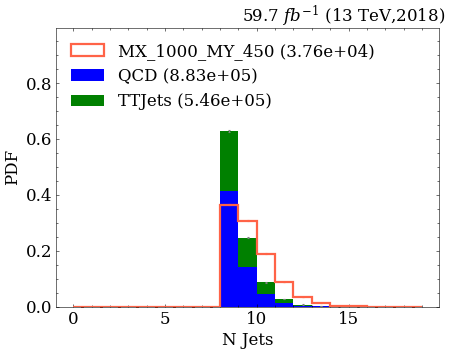

In [43]:
study.quick(
  signal+bkg, stacked=True, legend=True,
  varlist=['n_jet'],
  binlist=[np.arange(0,20)],
  efficiency=True,
  saveas='n_jet'
)

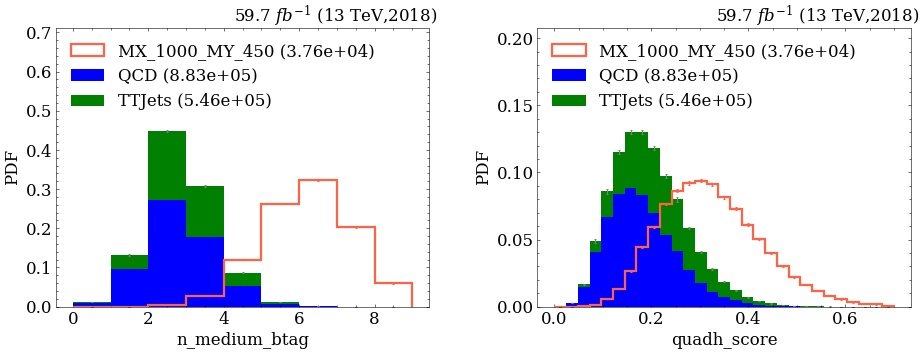

In [22]:
study.quick(
  signal+bkg, stacked=True, legend=True,
  varlist=['n_medium_btag','quadh_score'],
  binlist=[None, (0,0.7,30)],
  efficiency=True,
  saveas='selection_variables'
)

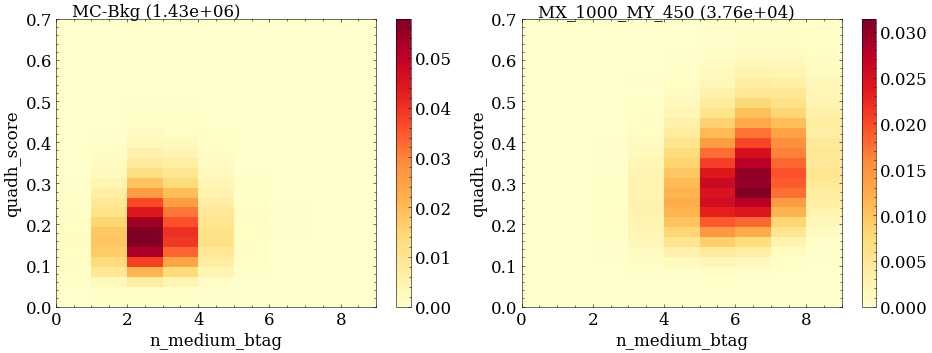

In [64]:
# fig, axs = plt.subplots(ncols=2, figsize=(16,8))
fig, axs = study.get_figax(2)

study.quick2d_region(
  bkg, label=['MC-Bkg'],
  varlist=['n_medium_btag','quadh_score'],
  binlist=[None, (0,0.7,30)],
  efficiency=True,
  figax=(fig,axs[0])
)

study.quick2d(
  signal,
  varlist=['n_medium_btag','quadh_score'],
  binlist=[None, (0,0.7,30)],
  efficiency=True,
  figax=(fig,axs[1])
)

fig.tight_layout()

study.save_fig(fig, '', 'selection_variables_2d')

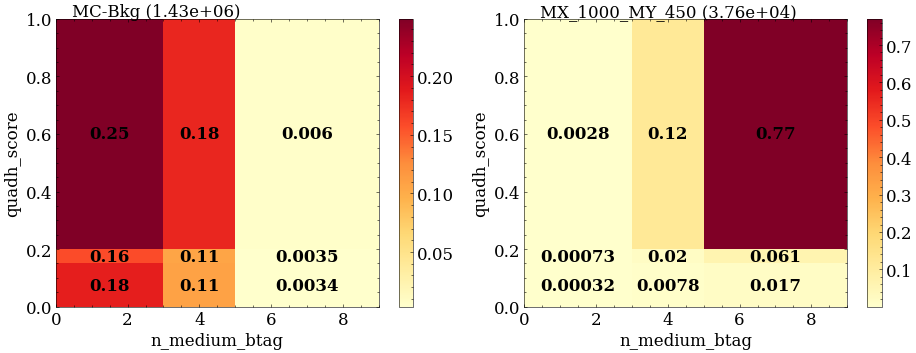

In [23]:
# fig, axs = plt.subplots(ncols=2, figsize=(16,8))
fig, axs = study.get_figax(2)

study.quick2d_region(
  bkg, label=['MC-Bkg'],
  varlist=['n_medium_btag','quadh_score'],
  binlist=[np.array((0,3,5,9)), np.array((0,0.15,0.2,1))],
  efficiency=True,
  show_counts=True,
  figax=(fig,axs[0])
)

study.quick2d(
  signal,
  varlist=['n_medium_btag','quadh_score'],
  binlist=[np.array((0,3,5,9)), np.array((0,0.15,0.2,1))],
  efficiency=True,
  show_counts=True,
  figax=(fig,axs[1])
)

fig.tight_layout()

study.save_fig(fig, '', 'full_abcd_regions')

In [24]:
def get_abcd_masks(v1_r, v2_r):
  v1_sr = lambda t : (t.n_medium_btag >= v1_r[1]) & (t.n_medium_btag < v1_r[2])
  v1_cr = lambda t : (t.n_medium_btag >= v1_r[0]) & (t.n_medium_btag < v1_r[1])

  v2_sr = lambda t : (t.quadh_score >= v2_r[1]) & (t.quadh_score < v2_r[2])
  v2_cr = lambda t : (t.quadh_score >= v2_r[0]) & (t.quadh_score < v2_r[1])

  r_a = lambda t : v1_sr(t) & v2_sr(t)
  r_b = lambda t : v1_cr(t) & v2_sr(t)

  r_c = lambda t : v1_sr(t) & v2_cr(t)
  r_d = lambda t : v1_cr(t) & v2_cr(t)
  return r_a, r_b, r_c, r_d

def get_abcd_scale(r_a, r_b, r_c, r_d):
  n_d = bkg.apply(lambda t:t.scale[r_d(t)]).apply(np.sum).npy.sum()
  n_c = bkg.apply(lambda t:t.scale[r_c(t)]).apply(np.sum).npy.sum()
  n_b = bkg.apply(lambda t:t.scale[r_b(t)]).apply(np.sum).npy.sum()
  n_a = bkg.apply(lambda t:t.scale[r_a(t)]).apply(np.sum).npy.sum()
  k_factor = n_c/n_d
  k_target = n_a/n_b
  return k_target, k_factor

In [25]:
abcd_regions = {
  'nominal':                    [(0,5,9),(0,0.2 ,1)],
  'validation/btag_hi':         [(3,5,9),(0,0.2 ,1)],
  'validation/btag_lo':         [(0,3,5),(0,0.2 ,1)],
  'validation/score_lo':        [(0,5,9),(0,0.15,0.2)],
  'validation/btag_hi_score_lo':[(3,5,9),(0,0.15,0.2)],
  'validation/btag_lo_score_lo':[(0,3,5),(0,0.15,0.2)]
}

In [27]:
v1_r, v2_r = abcd_regions['nominal']
r_a, r_b, r_c, r_d = get_abcd_masks(v1_r, v2_r)
k_target, k_factor = get_abcd_scale(r_a, r_b, r_c, r_d)

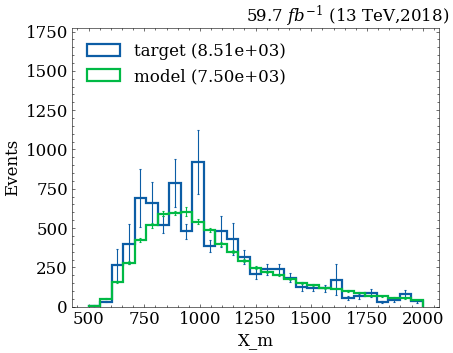

In [34]:
study.quick_region(
  bkg, bkg, 
  varlist=['X_m'],
  h_color=None, label=['target','model'], legend=True,
  masks=[r_a]*len(bkg) + [r_b]*len(bkg),
  scale=[None]*len(bkg) + [k_factor]*len(bkg),
  h_label_stat=lambda h:f'{np.sum(h.weights):0.2e}',
  saveas='model_X_m'
)

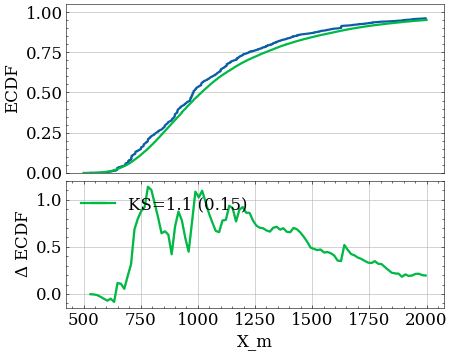

In [35]:
study.quick_region(
  bkg, bkg, 
  varlist=['X_m'],
  h_color=None, label=['target','model'], legend=True,
  masks=[r_a]*len(bkg) + [r_b]*len(bkg),
  scale=[None]*len(bkg) + [k_factor]*len(bkg),
  h_label_stat=lambda h:f'{np.sum(h.weights):0.2e}',

  histo=False,
  empirical=True,
  e_difference=True,
  e_d_size='75%',
  e_d_ylabel='$\Delta$ ECDF',
  e_d_legend_loc='upper left',

  saveas='model_X_m_kstest'
)

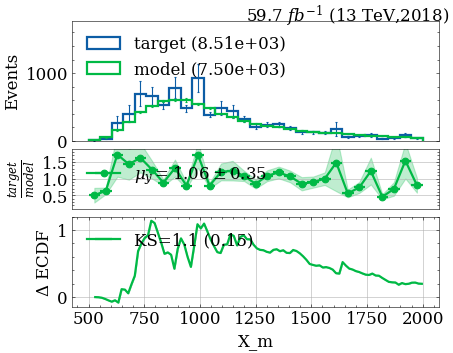

In [38]:
study.quick_region(
  bkg, bkg, 
  varlist=['X_m'],
  h_color=None, label=['target','model'], legend=True,
  masks=[r_a]*len(bkg) + [r_b]*len(bkg),
  scale=[None]*len(bkg) + [k_factor]*len(bkg),
  h_label_stat=lambda h:f'{np.sum(h.weights):0.2e}',
  legend_loc='upper left',

  ratio=True,
  r_size='50%',
  r_fill_error=True,
  r_ylabel=r'$\frac{target}{model}$',
  r_label_stat='y_mean_std',
  r_legend=True,
  r_legend_loc='upper left',

  empirical=True,
  # e_ylim=(-0.15,1.15),
  e_show=False,

  e_difference=True,
  e_d_size='75%',
  e_d_ylabel='$\Delta$ ECDF',
  e_d_legend_loc='upper left',

  saveas='model_X_m_full'
)